# **NLP** Natural Language Processing

Nuestro objetivo es construir un clasificador que sea capaz de distinguir entre noticias falsas y noticias reales.

In [1]:
# ========================
# IMPORTAR LIBRERIAS
#=========================

# Manipulación de datos
import pandas as pd
import numpy as np

# Deep Learning
import torch
import tensorflow as tf

# BERT & NLP
from transformers import BertTokenizer, BertForSequenceClassification, BertModel

# Métricas y utilidades
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# El nuevo clasificador
from xgboost import XGBClassifier

seed = 1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#===============================================================================
# CARGAMOS CON LOS CSV Y ASIGNAMOS NOMBRES A LAS COLUMNAS
#===============================================================================

train_df = pd.read_csv('/content/training_data.csv', sep='\t', header=None, names=['label', 'title'])
test_df = pd.read_csv('/content/testing_data.csv', sep='\t', header=None, names=['label', 'title'])

In [5]:
#===============================================================================
# VERIFICAR LOS DF
#===============================================================================

print(f"Training data head:\n{train_df.head()}")
print()
print(f"Testing data head:\n{test_df.head()}")
print()
print(f"Training data info:\n{train_df.info()}")
print()
print(f"Testing data info:\n{test_df.info()}")
print()

Training data head:
   label                                              title
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...

Testing data head:
  label                                              title
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   34152 non-null  int64 
 1   title   34152 non-null  

In [6]:
#===============================================================================
# PREPARACIÓN DE BERT
#===============================================================================

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
#===============================================================================
# EXTRACCIÓN DE EMBEDDINGS
#===============================================================================

def get_bert_embeddings(sentences, batch_size=16):
    bert_model.eval()  # Modo evaluación (importante en PyTorch)
    all_embeddings = []

    # Usamos torch.no_grad() para no consumir memoria innecesaria en el entrenamiento
    with torch.no_grad():
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size].tolist()
            # Tokenización para PyTorch (return_tensors='pt')
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=128)
            outputs = bert_model(**inputs)

            # Extraemos el vector del token [CLS] (índice 0) que representa la frase completa
            cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            all_embeddings.append(cls_embeddings)

    return np.vstack(all_embeddings)

In [8]:
#===============================================================================
# PROCESAMOS UNA MUESTRA PARA EL ENTRENAMIENTO
#===============================================================================

sample_train = train_df.sample(3000, random_state=seed)
print("Extrayendo embeddings de BERT con PyTorch...")
X_embeddings = get_bert_embeddings(sample_train['title'])
y = sample_train['label'].values


Extrayendo embeddings de BERT con PyTorch...


In [9]:
print(f"X_embeddings shape: {X_embeddings.shape}")
print(f"y shape: {y.shape}")

X_embeddings shape: (3000, 768)
y shape: (3000,)


In [10]:
#===============================================================================
#ENTRENAMIENTO XGBOOST
#===============================================================================

X_train, X_val, y_train, y_val = train_test_split(X_embeddings, y, test_size=0.2, random_state=seed)

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.18,
    max_depth=7,
    eval_metric='logloss'
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [11]:
#===============================================================================
# EXTRACCION DE METRICAS DE ENTRENAMIENTO
#===============================================================================

# Obtener el historial de métricas
results = xgb_model.evals_result()

# Loss
train_loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

# Accuracy (calculada manualmente por iteración)
train_acc = []
val_acc = []

from sklearn.metrics import accuracy_score
import numpy as np

for i in range(len(train_loss)):
    train_preds = xgb_model.predict(X_train, iteration_range=(0, i+1))
    val_preds = xgb_model.predict(X_val, iteration_range=(0, i+1))

    train_acc.append(accuracy_score(y_train, train_preds))
    val_acc.append(accuracy_score(y_val, val_preds))


In [12]:
# ==============================================================================
# EVALUACION Y ACCURACY ESTIMADA
# ==============================================================================

val_preds = xgb_model.predict(X_val)
acc = accuracy_score(y_val, val_preds)
print("Informe de clasificación:")
print(classification_report(y_val, val_preds))
print(f"\nExactitud estimada en validación: {accuracy_score(y_val, val_preds)*100:.2f}%")
print()

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       304
           1       0.94      0.94      0.94       296

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600


Exactitud estimada en validación: 94.33%



>>> Apartado 6: Generando Matriz de Confusión...
✓ Gráfico 'matriz_confusion.png' generado.


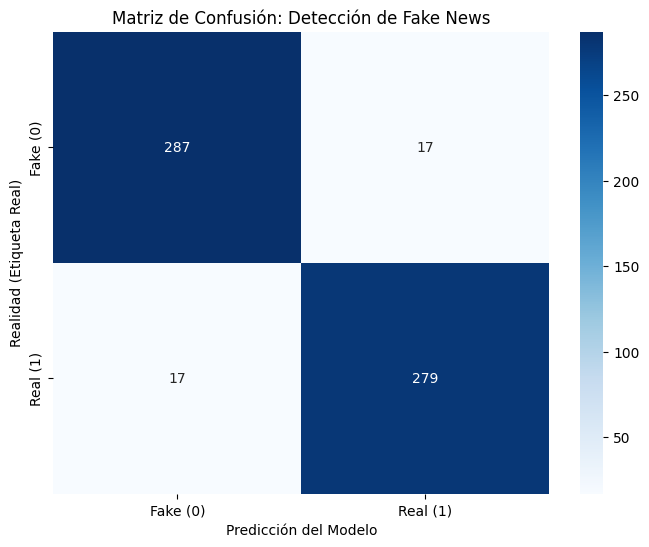

In [13]:
#===============================================================================
# MATRIZ DE CONFUSION
#===============================================================================

print(">>> Apartado 6: Generando Matriz de Confusión...")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Calculamos la matriz con los datos de validación
# val_preds son las predicciones y y_val son las etiquetas reales
cm = confusion_matrix(y_val, val_preds)

# 2. Creamos el Heatmap de 2x2
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake (0)', 'Real (1)'],
            yticklabels=['Fake (0)', 'Real (1)'])

plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad (Etiqueta Real)')
plt.title('Matriz de Confusión: Detección de Fake News')

# Guardamos el gráfico para la presentación
plt.savefig('matriz_confusion.png')
print("✓ Gráfico 'matriz_confusion.png' generado.")

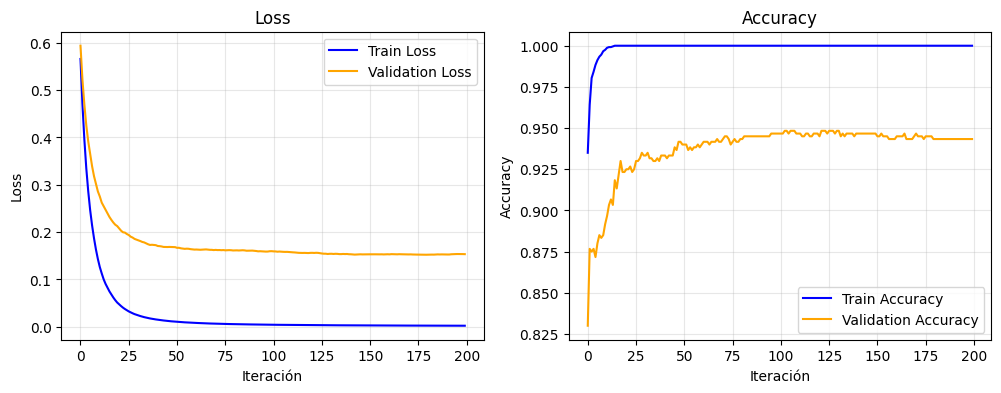

In [14]:
#===============================================================================
# CURVAS DE APRENDIZAJE XGBOOST (LOSS Y ACCURACY)
#===============================================================================

# Extraer métricas de entrenamiento
results = xgb_model.evals_result()

train_loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

# Cálculo manual del accuracy por iteración
train_acc = []
val_acc = []

from sklearn.metrics import accuracy_score

for i in range(len(train_loss)):
    train_preds = xgb_model.predict(X_train, iteration_range=(0, i+1))
    val_preds = xgb_model.predict(X_val, iteration_range=(0, i+1))

    train_acc.append(accuracy_score(y_train, train_preds))
    val_acc.append(accuracy_score(y_val, val_preds))


#===============================================================================
# GRAFICOS
#===============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de Loss
axes[0].plot(train_loss, label='Train Loss', color='blue')
axes[0].plot(val_loss, label='Validation Loss', color='orange')
axes[0].set_xlabel('Iteración')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de Accuracy
axes[1].plot(train_acc, label='Train Accuracy', color='blue')
axes[1].plot(val_acc, label='Validation Accuracy', color='orange')
axes[1].set_xlabel('Iteración')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()



In [15]:
# ==============================================================================
# GENERACIÓN DEL ARCHIVO DE PREDICCIONES
# ==============================================================================

print("Generando predicciones para testing_data.csv...")
X_test_embeddings = get_bert_embeddings(test_df['title'])
test_predictions = xgb_model.predict(X_test_embeddings)

# Reemplazamos los '2' por nuestras predicciones reales (0 o 1)
test_df['label'] = test_predictions

# Guardamos respetando el formato original: separador tabulador y sin cabecera
test_df.to_csv('predictions.csv', sep='\t', index=False, header=False)
print("¡Proceso finalizado! El archivo 'predictions.csv' está listo para entregar.")

Generando predicciones para testing_data.csv...
¡Proceso finalizado! El archivo 'predictions.csv' está listo para entregar.


In [16]:
# ==============================================================================
# EXPORTACION DEL NUEVO CSV
# ==============================================================================

from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>